**Predictive Modeling for the Indian Condom Market**

**Objective:** To train a robust machine learning model to predict `Market Size (USD Million)`. This notebook covers data preparation, building a scikit-learn pipeline, training a Random Forest Regressor, evaluating its performance, and saving the final model for future use.

Setup and Data Loading

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import joblib

In [25]:
# Set plot style
sns.set_theme(style="whitegrid", palette="deep")
plt.rcParams['figure.figsize'] = (12, 8)

In [26]:
# Load the dataset
df = pd.read_csv('data/India_Condom_Market_Dataset.csv')

In [27]:

# CRITICAL FIX: Strip whitespace from all column names to prevent KeyErrors
df.columns = df.columns.str.strip()

print("✅ Dataset loaded and column names cleaned successfully!")

✅ Dataset loaded and column names cleaned successfully!


**Feature Selection and Preprocessing**

In [28]:
# Define the target variable
TARGET = 'Market Size (USD Million)'

# Drop columns that are not suitable as predictive features
# Event Date is too specific, and the others are high-cardinality text fields
features_to_drop = [TARGET, 'Event Date', 'Company Involved', 'Event Details', 'Event Name']

X = df.drop(columns=features_to_drop)
y = df[TARGET]

print(f"Target variable: '{TARGET}'")
print(f"Number of features: {X.shape[1]}")
print("\n--- Features Used for Prediction ---")
print(X.columns.tolist())

# Identify categorical and numerical features for the preprocessor
categorical_features = X.select_dtypes(include=['object']).columns
numerical_features = X.select_dtypes(include=np.number).columns

print(f"\nIdentified {len(categorical_features)} categorical features.")
print(f"Identified {len(numerical_features)} numerical features.")

Target variable: 'Market Size (USD Million)'
Number of features: 14

--- Features Used for Prediction ---
['Year', 'CAGR (%)', 'Material Type', 'Product Type', 'Distribution Channel', 'Region', 'Market Penetration', 'Growth Rate (%)', 'Brand Name', 'Market Share (%)', 'Revenue Contribution (%)', 'Innovation Index', 'Regulatory Impact', 'Awareness Campaign Impact']

Identified 7 categorical features.
Identified 7 numerical features.


**Building the Preprocessing and Modeling Pipeline**

In [29]:
# A `Pipeline` is the best way to assemble our workflow. It will:
# 1.  **One-Hot Encode** all categorical features.
# 2.  Pass through numerical features without change.
# 3.  Train a `RandomForestRegressor` model on the processed data.

# Create the preprocessor object using ColumnTransformer
# This applies different transformations to different columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough' # Keep other columns if any (safer)
)

# Define the model - RandomForest is a powerful and robust choice for tabular data
regressor = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)

# Create the full pipeline
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', regressor)
])

print("✅ Model pipeline created successfully!")
print(model_pipeline)

✅ Model pipeline created successfully!
Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', 'passthrough',
                                                  Index(['Year', 'CAGR (%)', 'Growth Rate (%)', 'Market Share (%)',
       'Revenue Contribution (%)', 'Innovation Index',
       'Awareness Campaign Impact'],
      dtype='object')),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index(['Material Type', 'Product Type', 'Distribution Channel', 'Region',
       'Market Penetration', 'Brand Name', 'Regulatory Impact'],
      dtype='object'))])),
                ('regressor',
                 RandomForestRegressor(n_jobs=-1, random_state=42))])


**Splitting Data, Training, and Evaluation**

In [30]:
# We'll split our data into training and testing sets (80/20 split), train the pipeline, and then evaluate its performance on the unseen test data.

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set size: {X_train.shape[0]} samples")
print(f"Testing set size: {X_test.shape[0]} samples")

# Train the model pipeline on the training data
print("\nTraining the model...")
model_pipeline.fit(X_train, y_train)
print("✅ Model training complete!")

Training set size: 40000 samples
Testing set size: 10000 samples

Training the model...
✅ Model training complete!


In [31]:
# Make predictions on the test set
print("\n--- Model Evaluation ---")
y_pred = model_pipeline.predict(X_test)

# Calculate evaluation metrics
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"R-squared (R²): {r2:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

# An R² value close to 1.0 indicates that our model explains a large portion of the variance in the target variable.



--- Model Evaluation ---
R-squared (R²): -0.0210
Mean Absolute Error (MAE): 301.93
Root Mean Squared Error (RMSE): 350.16


**Visualizing Predictions vs. Actuals**

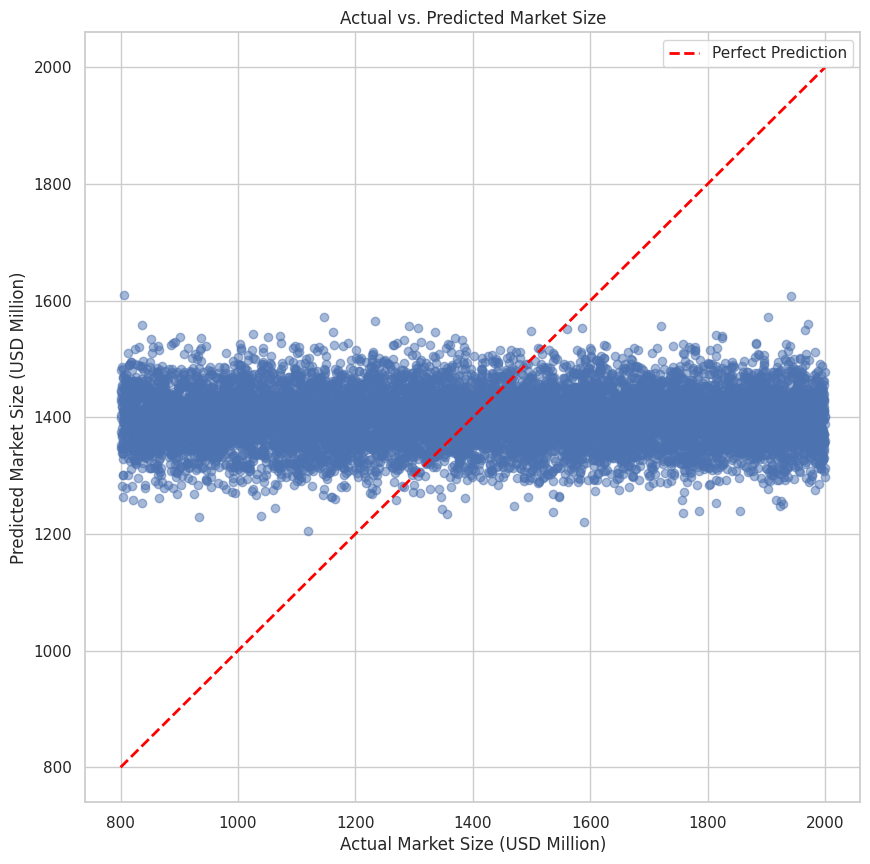

In [32]:
# A scatter plot helps to visually assess the model's performance. A perfect model would have all points lying on the diagonal line.
plt.figure(figsize=(10, 10))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', lw=2, color='red', label='Perfect Prediction')
plt.xlabel('Actual Market Size (USD Million)')
plt.ylabel('Predicted Market Size (USD Million)')
plt.title('Actual vs. Predicted Market Size')
plt.legend()
plt.show()


**Feature Importance**

/tmp/ipython-input-3829035861.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=feature_importance_df, palette='plasma')


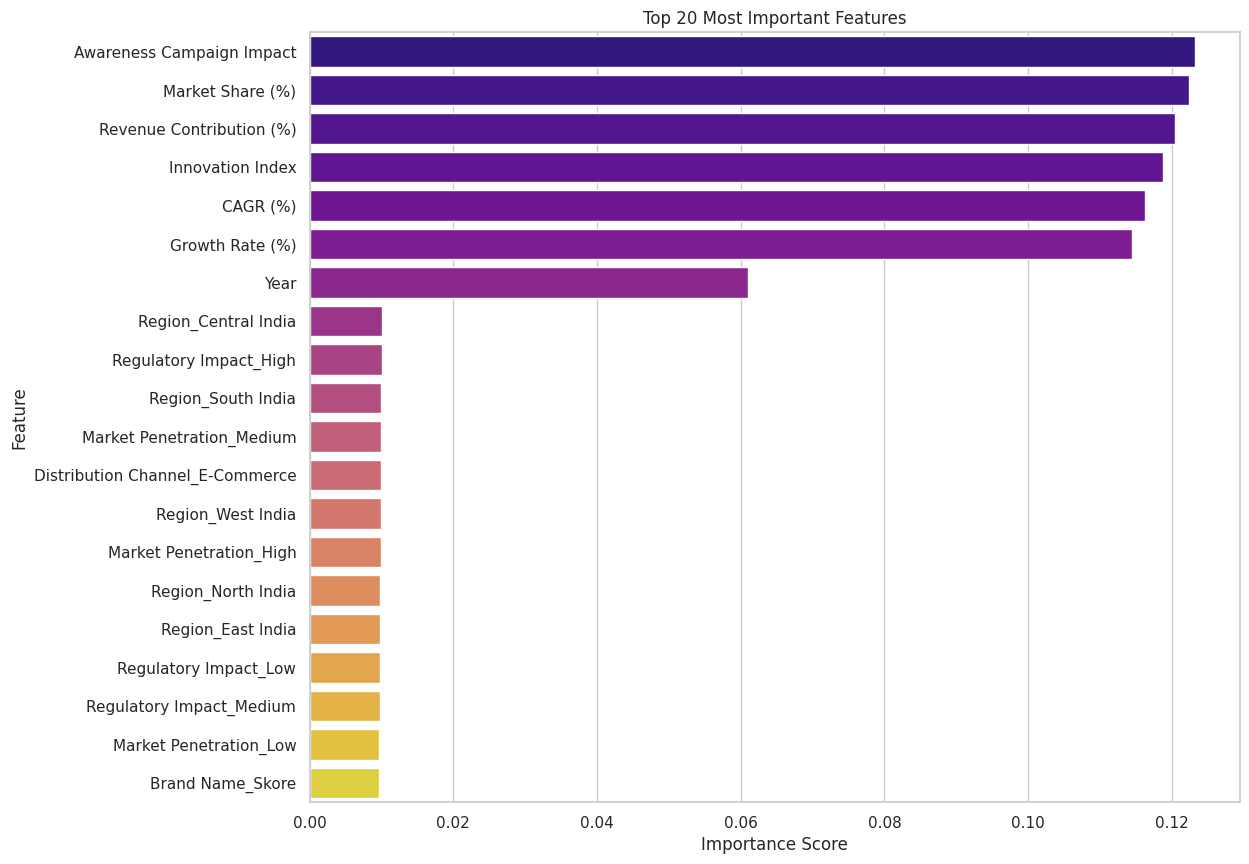

In [33]:
# Let's inspect our trained model to see which features it considered most important for making predictions.
# Extract feature names after one-hot encoding
ohe_feature_names = model_pipeline.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(categorical_features)
all_feature_names = np.concatenate([numerical_features, ohe_feature_names])

# Get feature importances from the trained model
importances = model_pipeline.named_steps['regressor'].feature_importances_

# Create a DataFrame for visualization
feature_importance_df = pd.DataFrame({
    'feature': all_feature_names,
    'importance': importances
}).sort_values('importance', ascending=False).head(20) # Top 20 features

# Plot the feature importances
plt.figure(figsize=(12, 10))
sns.barplot(x='importance', y='feature', data=feature_importance_df, palette='plasma')
plt.title('Top 20 Most Important Features')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.show()


**Saving the Model**

In [34]:
# Finally, we'll save the trained pipeline using `joblib`. This serialized file contains the entire workflow and can be loaded into another application (like a Streamlit dashboard) to make new predictions.

# Define the save path (make sure the 'models' directory exists)
import os
os.makedirs('models', exist_ok=True)
model_path = 'models/market_size_predictor.pkl'

# Save the model pipeline
joblib.dump(model_pipeline, model_path)

print(f"✅ Model pipeline saved successfully to: {model_path}")

# --- Cell 17: Code ---
# --- Optional: Loading and Verifying the Model ---
# This shows how you would load the model back into memory to use it
loaded_model = joblib.load(model_path)
print("\n✅ Model loaded successfully from file.")

# Verify by making a prediction on a sample data point
sample_prediction = loaded_model.predict(X_test.head(1))
print(f"Verified prediction on a sample: {sample_prediction[0]:.2f}")

✅ Model pipeline saved successfully to: models/market_size_predictor.pkl

✅ Model loaded successfully from file.
Verified prediction on a sample: 1312.91
